# Imports

In [1]:
import time, tqdm
import numpy as np
import pandas as pd
import numpy.random as rgt
import scipy.stats as spstat
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from joblib import Parallel, delayed
from quantes.linear import low_dim, high_dim, cv_lambda, validate_lambda
from utl import cov_generate

# Number of simulations
M = 50

# Simulation Studies of Sparse Linear QR Models (Estimation)

## Model 1

Let $z=(z_1, \ldots, z_p)^T \sim N(0, \Sigma)$ with $\Sigma = (0.5^{|j-k|})_{1\leq j, k \leq p}$. Generate independent data vectors $\{(y_i , x_i) \}_{i=1}^n$ from the model $y_i =   \langle x_i, \beta^*  \rangle    + 0.7 x_{i1}  \varepsilon_i$, where $x_i = (x_{i1}, \ldots, x_{ip})^T \sim (\Phi(z_1), z_2, \ldots, z_p)^T$, $\varepsilon_i \sim N(0,1)$ are independent of $x_i$, and $\beta^* \in \mathbb R^p$ is sparse with $\beta^*_6 = \beta^*_{12} =\beta^*_{15} = \beta^*_{20} =1$.

Consider two quantile levels: $\tau=0.5$ and $\tau=0.7$. Note that the effect of $x_{i1}$ is only present for $\tau=0.7$.

In [2]:
n, p = 300, 1000
Mu, Sig = np.zeros(p), cov_generate(np.ones(p))
beta = np.zeros(p)
beta[[5, 11, 14, 19]] = 1

def model1_sim(m=0, tau=0.5):
    rgt.seed(m)
    true_beta = np.copy(beta)
    true_beta[0] = 0.7*spstat.norm.ppf(tau)
    true_set = np.where(true_beta!=0)[0]

    runtime = np.zeros(3)
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    X[:,0] = spstat.norm.cdf(X[:,0])
    Y = X@beta + 0.7*X[:,0]*rgt.normal(0,1,size=n)

    sqr = high_dim(X, Y, intercept=False)
    sim_lambda = np.quantile(sqr.tuning(tau), 0.95)
    
    ## l1-penalized conquer (l1 conquer)
    tic = time.time()
    l1_model = sqr.l1(tau, 0.7*sim_lambda)
    runtime[0] += time.time() - tic

    ## Iteratively reweighted l1-penalized conquer (IRW-l1 conquer)
    tic = time.time()
    irw_model = sqr.irw(tau, 0.7*sim_lambda)
    runtime[1] += time.time() - tic

    ## Oracle conquer
    tic = time.time()
    ora_model = low_dim(X[:,true_set], Y, intercept=False).fit(tau=tau)
    runtime[2] += time.time() - tic
    
    est = np.c_[(l1_model['beta'], irw_model['beta'], np.zeros(p))]
    est[:,2][true_beta!=0] = ora_model['beta']
    est = pd.DataFrame(est)

    err = (est - true_beta[:,None]).pow(2).sum(axis=0)
    tp = (est.ne(0) * (true_beta!=0)[:,None]).sum(axis=0)
    fp = (est.ne(0) * (true_beta==0)[:,None]).sum(axis=0)
    return runtime, err, tp, fp

### Case 1: $\tau=0.5$.

In [3]:
results1 = Parallel(n_jobs=-1)(delayed(model1_sim)(m, tau=0.5) for m in range(M))
runtime, coef_err, tp, fp = zip(*results1)
out1 = pd.DataFrame(np.array([np.mean(coef_err, axis=0), 
                              np.std(coef_err, axis=0),
                              np.mean(tp, axis=0), 
                              np.mean(fp, axis=0), 
                              np.mean(runtime, axis=0)]),
                    columns=['l1-conquer', 'irw-conquer', 'oracle-conquer'],
                    index=['coef err', '(std)', 'true pos', 'false pos', 'runtime'])
print(out1)
print('\nX1 selection rate:', np.mean(np.array(tp)[:,1]==5))

           l1-conquer  irw-conquer  oracle-conquer
coef err     0.035649     0.001645        0.001435
(std)        0.013133     0.001129        0.001016
true pos     4.000000     4.000000        4.000000
false pos    0.160000     0.000000        0.000000
runtime      0.015121     0.025945        0.001031

X1 selection rate: 0.0


### Case 2: $\tau=0.7$.

In [4]:
results2 = Parallel(n_jobs=-1)(delayed(model1_sim)(m, tau=0.7) for m in range(M))
runtime, coef_err, tp, fp = zip(*results2)
out2 = pd.DataFrame(np.array([np.mean(coef_err, axis=0), 
                              np.std(coef_err, axis=0),
                              np.mean(tp, axis=0), 
                              np.mean(fp, axis=0), 
                              np.mean(runtime, axis=0)]),
                    columns=['l1-conquer', 'irw-conquer', 'oracle-conquer'],
                    index=['coef err', '(std)', 'true pos', 'false pos', 'runtime'])
print(out2)
print('\nX1 selection rate:', np.mean(np.array(tp)[:,1]==5))

           l1-conquer  irw-conquer  oracle-conquer
coef err     0.035701     0.005972        0.006352
(std)        0.012981     0.005182        0.005304
true pos     5.000000     5.000000        5.000000
false pos    0.300000     0.060000        0.000000
runtime      0.027907     0.046852        0.000859

X1 selection rate: 1.0


## Model 2

Construct the covariance matrix $\Sigma = (\sigma_j \sigma_k 0.5^{|j-k|})_{1\leq j, k \leq p}$, where $\sigma_1, \ldots, \sigma_p$ are iid from ${\rm Uniform}(1,2)$.

Generate independent data vectors $\{(y_i , x_i) \}_{i=1}^n$ from the model $y_i =  4 + \langle x_i, \beta^*  \rangle    +   \varepsilon_i - F_{ \varepsilon_i}^{-1}(\tau)$, where $x_i \sim N(0, \Sigma)$ and $\varepsilon_i \sim t_2$ are independent, and $\beta^* \in \mathbb R^p$ is sparse.

In [5]:
n, p = 256, 1028
tau = 0.75
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
itcp, beta = 4, np.zeros(p)
beta[:15] = [1.6, 0, 1.4, 0, 1.2, 0, 1, 0, -1, 0, -1.2, 0, -1.4, 0, -1.6]
true_set = np.where(beta!=0)[0]
true_loc = np.zeros(p)
true_loc[true_set] = 1

### 2.1. Simulation results for $\ell_1$- and iteratively reweighted $\ell_1$-penalized conquer

The penality level $\lambda>0$ is determined by a simulation-based method.

In [6]:
def model2_sim1(m=0):
    rgt.seed(m)
    runtime = np.zeros(3)
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp*np.ones(n) + X.dot(beta) + rgt.standard_t(2,size=n) - spstat.t.ppf(tau,df=2)

    sqr = high_dim(X, Y)
    sim_lambda = np.quantile(sqr.tuning(tau), 0.95)

    ## l1-penalized conquer
    tic = time.time()
    l1 = sqr.l1(tau=tau, Lambda=0.7*sim_lambda)
    runtime[0] += time.time() - tic

    ## Iteratively reweighted l1-penalized conquer (default is SCAD penality)
    tic = time.time()
    irw = sqr.irw(tau=tau, Lambda=0.7*sim_lambda)
    runtime[1] += time.time() - tic

    ## Oracle conquer
    tic = time.time()
    sqr = low_dim(X[:,true_set], Y)
    ora = sqr.fit(tau=tau)
    runtime[2] += time.time() - tic
    
    est = np.c_[(l1['beta'], irw['beta'], np.zeros(p+1))]
    est[0,2], est[1:,2][beta!=0] = ora['beta'][0], ora['beta'][1:]
    est = pd.DataFrame(est)
    
    itcp_err = (est.iloc[0] - itcp).abs()
    coef_err = (est.iloc[1:] - beta[:,None]).pow(2).sum(axis=0)
    tp = (est.iloc[1:].ne(0) * (beta!=0)[:,None]).sum(axis=0)
    fp = (est.iloc[1:].ne(0) * (beta==0)[:,None]).sum(axis=0)
    return runtime, itcp_err, coef_err, tp, fp

results3 = Parallel(n_jobs=-1)(delayed(model2_sim1)(m) for m in range(M))
runtime, itcp_err, coef_err, tp, fp = zip(*results3)
out3 = {'itcp err':   np.mean(itcp_err, axis=0), '(itcp std)': np.std(itcp_err, axis=0), 
        'coef err':   np.mean(coef_err, axis=0), '(coef std)': np.std(coef_err, axis=0),
        'true pos':   np.mean(tp, axis=0), 
        'false pos':  np.mean(fp, axis=0),
        'runtime':    np.mean(runtime, axis=0)}
pd.DataFrame(out3, index=['l1', 'irw-l1','oracle'])

,itcp err,(itcp std),coef err,(coef std),true pos,false pos,runtime
l1,0.478740,0.230417,0.838852,0.412806,8.0,3.64,0.043240
irw-l1,0.109089,0.103745,0.065801,0.043482,8.0,2.02,0.070076
oracle,0.111266,0.100534,0.062634,0.039741,8.0,0.00,0.001718


### 2.2. Solution paths of $\ell_1$- and iteratively reweighted $\ell_1$-penalized conquer

In [7]:
nlambda = 50
def model2_sim2(m):
    rgt.seed(m)
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp + X.dot(beta) + rgt.standard_t(2,size=n) - spstat.t.ppf(tau,df=2)
    sqr = high_dim(X, Y)

    l1 = sqr.l1_path(tau=tau, nlambda=nlambda, order='descend')
    irw = sqr.irw_path(tau=tau, lambda_seq=l1['lambda_seq'], order='descend')

    l1_sse = np.sum((l1['beta_seq'][1:,:] - beta[:,None])**2, axis=0)
    irw_sse = np.sum((irw['beta_seq'][1:,:] - beta[:,None])**2, axis=0)
    l1_loc = np.sign(abs(l1['beta_seq'][1:,:]))
    irw_loc = np.sign(abs(irw['beta_seq'][1:,:]))
    l1_tp = np.sum(l1_loc*true_loc[:,None], axis=0)
    irw_tp = np.sum(irw_loc*true_loc[:,None], axis=0)
    l1_fp = np.sum(l1_loc, axis=0) - l1_tp
    irw_fp = np.sum(irw_loc, axis=0) - irw_tp
    return l1_sse, irw_sse, l1_tp, irw_tp, l1_fp, irw_fp

results4 = Parallel(n_jobs=-1)(delayed(model2_sim2)(m) for m in range(M))
l1_sse, irw_sse, l1_tp, irw_tp, l1_fp, irw_fp = zip(*results4)
l1_sse = np.array(l1_sse).mean(axis=0)
irw_sse = np.array(irw_sse).mean(axis=0)
l1_tp, irw_tp, l1_fp, irw_fp = \
    np.array(l1_tp), np.array(irw_tp), np.array(l1_fp), np.array(irw_fp)

l1_tpr = l1_tp.mean(axis=0) / len(true_set)
irw_tpr = irw_tp.mean(axis=0) / len(true_set)
l1_fdr = (l1_fp/np.maximum(1, l1_fp + l1_tp)).mean(axis=0)
irw_fdr = (irw_fp/np.maximum(1, irw_fp + irw_tp)).mean(axis=0)

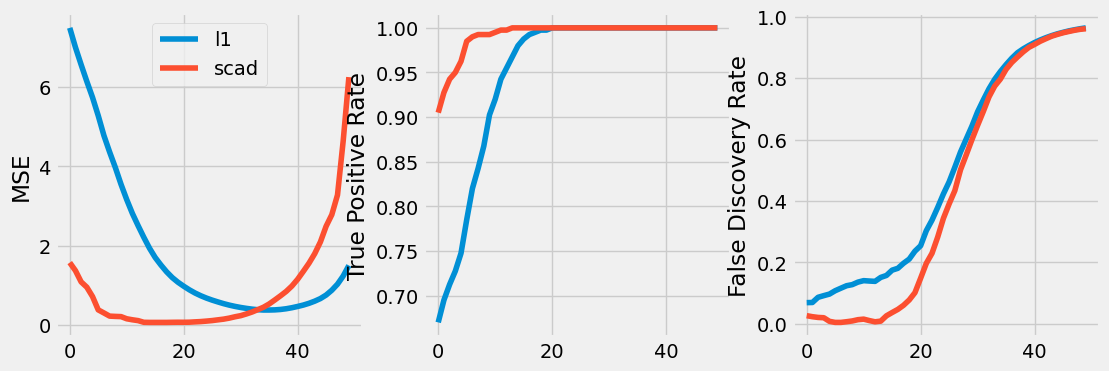

In [8]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(l1_sse, label='l1')
ax[0].plot(irw_sse, label='scad')
ax[0].set_ylabel('MSE')
ax[0].legend()

ax[1].plot(l1_tpr, label='l1')
ax[1].plot(irw_tpr, label='scad')
ax[1].set_ylabel('True Positive Rate')

ax[2].plot(l1_fdr, label='l1')
ax[2].plot(irw_fdr, label='scad')
ax[2].set_ylabel('False Discovery Rate')

plt.show()

### 2.3. Tune ($\ell_1$, SCAD, MCP) penalized conquer using a validation set

$\ell_1$-conquer: $\ell_1$-penalized conquer;

scad-conquer: iteratively reweighted $\ell_1$-penalized conquer using SCAD-based weights;

mcp-conquer: iteratively reweighted $\ell_1$-penalized conquer using MCP-based weights;

oracle: conquer estimator fitted on the true model.

In [9]:
n_val = 128
nlambda = 50
def model2_sim3(m):
    rgt.seed(m)
    X_all = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n+n_val)
    Y_all = itcp + X_all.dot(beta) + rgt.standard_t(2,n+n_val) - spstat.t.ppf(tau,df=2)
    X, Y = X_all[:n, :], Y_all[:n]
    X_val, Y_val = X_all[n:,:], Y_all[n:]

    sqr = validate_lambda(X, Y, X_val, Y_val, intercept=True)
    lam_max = np.max(high_dim(X, Y).tuning(tau))
    lambda_seq = np.linspace(0.25*lam_max, lam_max, num=nlambda)

    l1 = sqr.train(tau=tau, lambda_seq=lambda_seq, penalty="L1")
    scad = sqr.train(tau=tau, lambda_seq=lambda_seq, penalty="SCAD", a=3.7)
    mcp = sqr.train(tau=tau, lambda_seq=lambda_seq, penalty="MCP", a=3)
    ora = low_dim(X[:,true_set], Y).fit(tau=tau)

    est = np.c_[(l1['val_beta'], scad['val_beta'], mcp['val_beta'], np.zeros(p+1))]
    est[0,3], est[1:,3][beta!=0] =  ora['beta'][0], ora['beta'][1:]
    est = pd.DataFrame(est)
    
    val_out = np.zeros((4, 5))
    val_out[:,0] = (est.iloc[1:] - beta[:,None]).pow(2).sum(axis=0)
    val_out[:,1] = est.iloc[1:].ne(0).sum(axis=0)
    val_out[:,2] = (est.iloc[1:].ne(0) * (beta!=0)[:,None]).sum(axis=0)
    val_out[:,3] = val_out[:,1] - val_out[:,2]
    val_out[0,4] = l1['lambda_min']
    val_out[1,4] = scad['lambda_min']
    val_out[2,4] = mcp['lambda_min']
    return val_out

results5 = Parallel(n_jobs=-1)(delayed(model2_sim3)(m) for m in range(M))
val_out = np.array(results5)
out5 = pd.DataFrame(np.mean(val_out, axis=0),
                    index=['l1', 'scad', 'mcp', 'oracle'],
                    columns=['coef err', 'non-zero coef', 'true pos', 
                             'false pos', 'lambda_min'])
print(out5)

        coef err  non-zero coef  true pos  false pos  lambda_min
l1      0.392992          54.78       8.0      46.78    0.045601
scad    0.077535          11.02       8.0       3.02    0.091362
mcp     0.074117           9.72       8.0       1.72    0.096638
oracle  0.055992           8.00       8.0       0.00    0.000000


### 2.4. Cross-validated ($\ell_1$, SCAD, MCP) penalized conquer

In [10]:
nlambda = 50
def model2_sim4(m):
    rgt.seed(m)
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    sqr = cv_lambda(X, Y, intercept=True)

    cv_l1 = sqr.fit(tau=tau, nlambda=nlambda, penalty="L1", nfolds=8)
    cv_scad = sqr.fit(tau=tau, lambda_seq=cv_l1['lambda_seq'], penalty="SCAD", a=3.7, nfolds=8)
    cv_mcp = sqr.fit(tau=tau, lambda_seq=cv_l1['lambda_seq'], penalty="MCP", a=3, nfolds=8)
    ora = low_dim(X[:,true_set], Y).fit(tau=tau)

    est = np.c_[(cv_l1['cv_beta'], cv_scad['cv_beta'], cv_mcp['cv_beta'], np.zeros(p+1))]
    est[0,3], est[1:,3][beta!=0] = ora['beta'][0], ora['beta'][1:]
    est = pd.DataFrame(est)

    cv_out = np.zeros((4, 5))
    cv_out[:,0] = (est.iloc[1:] - beta[:,None]).pow(2).sum(axis=0)
    cv_out[:,1] = est.iloc[1:].ne(0).sum(axis=0)
    cv_out[:,2] = (est.iloc[1:].ne(0) * (beta!=0)[:,None]).sum(axis=0)
    cv_out[:,3] = cv_out[:,1] - cv_out[:,2]
    cv_out[:3,4] = np.array([cv_l1['lambda_min'], cv_scad['lambda_min'], cv_mcp['lambda_min']])

    cv_err = np.zeros((3, nlambda))
    cv_err[0,:] = cv_l1['cv_err']
    cv_err[1,:] = cv_scad['cv_err']
    cv_err[2,:] = cv_mcp['cv_err']
    return cv_out, cv_err

results6 = Parallel(n_jobs=-1)(delayed(model2_sim4)(m) for m in range(M))
cv_out, cv_err = zip(*results6)
cv_out, cv_err = np.array(cv_out), np.array(cv_err)

out6 = np.zeros((4, 5))
out6[0] = np.mean(cv_out[:,0,:,], axis=0)
out6[1] = np.mean(cv_out[:,1,:,], axis=0)
out6[2] = np.mean(cv_out[:,2,:,], axis=0)
out6[3] = np.mean(cv_out[:,3,:,], axis=0)
pd.DataFrame(out6, columns=['coef_mse','size','TP','FP','lambda_min'],
             index=["l1-conquer", "scad-conquer","mcp-conquer","oracle"])

,coef_mse,size,TP,FP,lambda_min
l1-conquer,0.400184,49.24,8.0,41.24,0.047587
scad-conquer,0.068017,9.08,8.0,1.08,0.098472
mcp-conquer,0.069863,8.40,8.0,0.40,0.103902
oracle,0.062634,8.00,8.0,0.00,0.000000


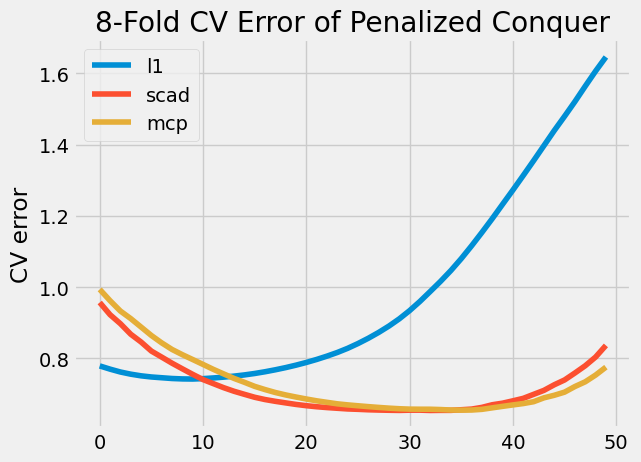

In [11]:
def plot_cv_err(y1, y2, y3):
    plt.clf()
    plt.plot(y1[::-1],label='l1')
    plt.plot(y2[::-1],label='scad')
    plt.plot(y3[::-1],label='mcp')
    plt.title("8-Fold CV Error of Penalized Conquer")
    plt.ylabel("CV error")
    plt.legend()
    plt.show()

plot_cv_err(cv_err[:,0,:].mean(axis=0),
            cv_err[:,1,:].mean(axis=0),
            cv_err[:,2,:].mean(axis=0))

### 2.5. Model selection via Bayesian Information Criterion (BIC)

In [12]:
def model2_sim5(m):
    rgt.seed(m)
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    sqr = high_dim(X, Y, intercept=True)
    bic_l1 = sqr.bic(tau=tau, penalty="L1")
    bic_scad = sqr.bic(tau=tau, penalty="SCAD")
    bic_mcp = sqr.bic(tau=tau, penalty="MCP")

    est = pd.DataFrame(np.c_[(bic_l1['bic_beta'], bic_scad['bic_beta'], bic_mcp['bic_beta'])])
    bic_out = np.zeros((3, 5))
    bic_out[:,0] = (est.iloc[1:] - beta[:,None]).pow(2).sum(axis=0)
    bic_out[:,1] = est.iloc[1:].ne(0).sum(axis=0)
    bic_out[:,2] = (est.iloc[1:].ne(0) * (beta!=0)[:,None]).sum(axis=0)
    bic_out[:,3] = bic_out[:,1] - bic_out[:,2]
    bic_out[:,4] = np.array([bic_l1['bic_lambda'], bic_scad['bic_lambda'], bic_mcp['bic_lambda']])
    return bic_out

results7 = Parallel(n_jobs=-1)(delayed(model2_sim5)(m) for m in range(M))
bic_out = np.array(results7)
out7 = np.mean(bic_out, axis=0)
pd.DataFrame(out7, columns=['coef_mse','size','TP','FP','lambda_min'],
             index=["l1-conquer", "scad-conquer","mcp-conquer"])

,coef_mse,size,TP,FP,lambda_min
l1-conquer,0.934816,10.1,7.96,2.14,0.079108
scad-conquer,0.061399,8.0,8.00,0.00,0.104658
mcp-conquer,0.061334,8.0,8.00,0.00,0.104177


# Simulation Studies of Sparse Linear QR Models (Inference)

In [14]:
s, p, n = 8, 1028, 256
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
beta = np.zeros(p)
beta[:21] = [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
             1, 0, 0,-1, 0, 0, -1, 0, 0, -1]
true_set = np.where(beta!=0)[0]
print('true model:', true_set+1)

def boot_sim(m, tau=0.5, df=2, itcp=True, 
             parallel=False, ncore=-1):
    rgt.seed(m)
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = 4 + X@beta + rgt.standard_t(2,n) - spstat.t.ppf(tau, df)
    
    sqr = high_dim(X, Y, intercept=itcp)
    lambda_sim = 0.75*np.quantile(sqr.tuning(tau), 0.9)
    boot_qr = sqr.boot_inference(tau=tau, Lambda=lambda_sim, 
                                 weight="Multinomial", 
                                 parallel=parallel, ncore=ncore)
    CIs = np.array([boot_qr['percentile'], boot_qr['pivotal'], boot_qr['normal']])    
    est_set = np.where(boot_qr['boot_beta'][itcp:,0]!=0)[0]
    tp =  len(np.intersect1d(true_set, est_set))
    fp  = len(np.setdiff1d(est_set, true_set))
    mb_tp = len(np.intersect1d(true_set, boot_qr['majority_vote']))
    mb_fp = len(np.setdiff1d(boot_qr['majority_vote'], true_set))
    ci_cover = np.c_[(beta>=CIs[0,1:,0])*(beta<=CIs[0,1:,1]), 
                     (beta>=CIs[1,1:,0])*(beta<=CIs[1,1:,1]),
                     (beta>=CIs[2,1:,0])*(beta<=CIs[2,1:,1])]
    ci_width = np.c_[CIs[0,1:,1] - CIs[0,1:,0],
                     CIs[1,1:,1] - CIs[1,1:,0],
                     CIs[2,1:,1] - CIs[2,1:,0]]            
    return {'tp': tp, 'fp': fp, 'mb_tp': mb_tp, 'mb_fp': mb_fp, 
            'ci_cover': ci_cover, 'ci_width': ci_width}

true model: [ 1  3  6  9 12 15 18 21]


In [15]:
M = 200
tp, fp = np.zeros(M), np.zeros(M)
mb_tp, mb_fp = np.zeros(M), np.zeros(M)
ci_cover, ci_width = np.zeros([p, 3]), np.zeros([p, 3])

runtime = []
for m in tqdm.tqdm(range(M)):
    tic = time.time()  
    out = boot_sim(m, tau=0.8, df=2, parallel=True, ncore=-1)
    runtime.append(time.time()-tic)
    
    tp[m], fp[m], mb_tp[m], mb_fp[m] \
        = out['tp'], out['fp'], out['mb_tp'], out['mb_fp']
    ci_cover += out['ci_cover']
    ci_width += out['ci_width']

100%|██████████| 200/200 [50:02<00:00, 15.01s/it]


In [16]:
cover = pd.DataFrame(ci_cover/M, columns=['percentile', 'pivotal', 'normal'])
width = pd.DataFrame(ci_width/M, columns=['percentile', 'pivotal', 'normal'])

boot_out = pd.concat([width.iloc[true_set,:], cover.iloc[true_set,:]], axis=1)
boot_out.index = boot_out.index + 1
print(boot_out)
print('-'*65)
print('average runtime (s):', np.mean(runtime).round(2),
      '\ntrue positive:', np.mean(tp), 
      '\nfalse positive:', np.mean(fp),
      '\nvariable selection prob:', np.mean((tp==8)*(fp==0)), 
      '\ntrue pos after boot:', np.mean(mb_tp),
      '\nfalse pos after boot:', np.mean(mb_fp),
      '\nvariable selection prob after boot:', np.mean((mb_tp==8)*(mb_fp==0)))

    percentile   pivotal    normal  percentile  pivotal  normal
1     0.290066  0.290066  0.295850       0.970    0.900   0.975
3     0.368152  0.368152  0.376335       0.955    0.900   0.925
6     0.344752  0.344752  0.351258       0.945    0.920   0.940
9     0.452932  0.452932  0.460495       0.975    0.920   0.955
12    0.312343  0.312343  0.315508       0.990    0.940   0.975
15    0.459500  0.459500  0.469331       0.980    0.950   0.960
18    0.326200  0.326200  0.330582       0.970    0.915   0.955
21    0.378684  0.378684  0.385794       0.945    0.905   0.950
-----------------------------------------------------------------
average runtime (s): 15.01 
true positive: 8.0 
false positive: 1.44 
variable selection prob: 0.215 
true pos after boot: 8.0 
false pos after boot: 0.035 
variable selection prob after boot: 0.965


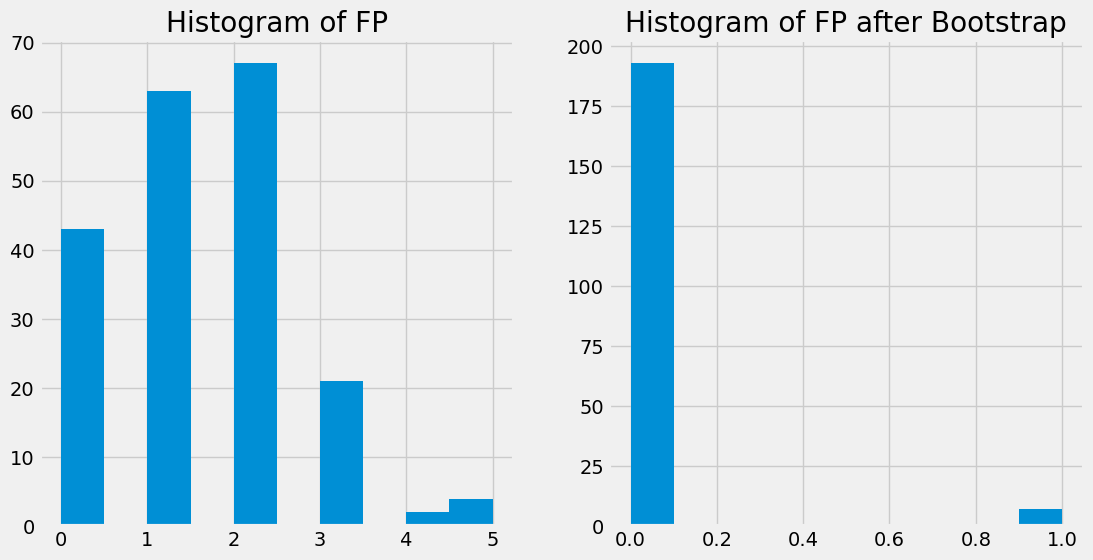

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].hist(fp)
ax[0].set_title('Histogram of FP')
ax[1].hist(mb_fp)
ax[1].set_title('Histogram of FP after Bootstrap')
plt.show()